# Compétition : Track and Field Time Prediction

Les domaines sportifs, comme l'athlétisme, mesurent leur performance avec une précision remarquable où chaque centième de seconde peut faire la différence. C'est dans cette optique que
la compétition présente le défi suivant : prédire le meilleur temps personnel d'un athlète sur 1500
mètres en exploitant ses performances antérieures sur d'autres distances ainsi que ses
caractéristiques démographiques. Ce défi permet de mettre en contexte une problématique réelle
dans le domaine des sports de compétition.

Face à cette problématique, l'approche que j’ai priorisée est une démarche expérimentale qui
compare plusieurs algorithmes de régression supervisée sur le jeu de données disponibles pour
cette compétition. Dans le choix des algorithmes sélectionnés, nous retrouvons la régression
linéaire, la forêt d'arbres de décision (Random Forest), le boosting de gradient, les k plus proches
voisins (K-NN), le support vector regression (SVR) avec noyau radial basis function (RBF),
l'arbre de décision et les réseaux de neurones.

Les résultats de cette démarche expérimentale révèlent que, bien que l'algorithme Gradient
Boosting obtienne les meilleures performances selon les métriques d'évaluation initiales, Random
Forest s'avère être l'algorithme qui généralise le mieux et offre donc des prédictions plus fiables.
En effet, les deux algorithmes présentent des performances similaires sur les métriques de base :
Gradient Boosting atteint un RMSE de 2998,69 contre 3047,81 pour Random Forest. Cependant,
l'analyse par validation croisée (CV RMSE) révèle une différence significative dans la capacité de
généralisation : Gradient Boosting présente une erreur relative de 114% en CV RMSE, tandis que
Random Forest maintient une erreur relative de seulement 63%. Ces résultats démontrent que
Random Forest offre une stabilité supérieure et une marge d'erreur plus faible, en faisant
l'algorithme optimal pour la prédiction des temps sur 1550 mètres.

### **Importation des libraries**

In [ ]:
!pip install scikeras
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import HTML, display
import seaborn as sns

### **Importation du jeu de données**

Le jeu de données utilisé pour cette analyse provient de la compétition Kaggle « Track and Field
Time Prediction ». Celui-ci est basé sur des informations collectées à partir du classement mondial
de World Athletics. On y retrouve les performances personnelles d'athlètes internationaux sur
plusieurs distances et disciplines, ainsi que leurs informations démographiques comme le pays,
l'âge et le genre.

In [ ]:
from google.colab import drive
PREFIX = '/content/drive'
drive.mount(PREFIX)
train = '/content/drive/MyDrive/track-and-field-time-prediction/train.csv'
test = '/content/drive/MyDrive/track-and-field-time-prediction/test.csv'


train_set= pd.read_csv(train)
test_set = pd.read_csv(test)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Nettoyage des données**

**Retrait des colonnes non pertinentes**

Dans le livre Hands-On Machine Learning with Scikit-Learn, Keras et TensorFlow (2e
éd.),
Aurélien Géron présente trois stratégies pour gérer les données manquantes :
- Supprimer les lignes,
- Supprimé la colonne entière,
- Ou remplacer par une statistique (moyenne, médiane, etc.)

C’est donc en suivant cette approche que la première étape du nettoyage des données consiste à
retirer les colonnes qui ne sont pas directement liées à la variable cible. Dans le cadre de cette
compétition, l’objectif est de prédire le temps d’un coureur sur la distance de 1500 mètres.
Toutefois, le jeu de données comprend également des disciplines qui ne sont pas pertinentes pour
cette prédiction, comme le relais (épreuve collective), le décathlon (qui combine plusieurs
disciplines, dont des sauts et des lancers), ainsi que d’autres épreuves sans lien direct avec la
course

In [ ]:
#Train
mots_a_supprimer = ['Relay', 'Medley', 'Hurdles', 'Steeplechase', 'Walk', 'Declathlon', 'Discus', 'Throw', 'Heptathlon', 'Jump', 'Pentathlon', 'Shot']
colonnes_a_supprimer_train = train_set.columns[train_set.columns.str.contains('|'.join(mots_a_supprimer), case=False, na=False)]

df_train = train_set.drop(columns=colonnes_a_supprimer_train)

print('Colonnes supprimées :', len(colonnes_a_supprimer_train), colonnes_a_supprimer_train)

#Test
colonnes_a_supprimer_test = test_set.columns[test_set.columns.str.contains('|'.join(mots_a_supprimer), case=False, na=False)]
df_test = test_set.drop(columns=colonnes_a_supprimer_test)

print('Colonnes supprimées :', len(colonnes_a_supprimer_test), colonnes_a_supprimer_test)

Colonnes supprimées : 50 Index(['10 Kilometres Race Walk', '10,000 Metres Race Walk',
       '100 Metres Hurdles', '100 Metres Hurdles (76.2cm)',
       '110 Metres Hurdles', '2000 Metres Steeplechase',
       '2000 Metres Steeplechase (0.84)',
       '2000 Metres Steeplechase Short Track', '2x2x400m Relay',
       '300 Metres Hurdles', '300 Metres Hurdles (84.0cm)',
       '3000 Metres Race Walk', '3000 Metres Steeplechase',
       '3000 Metres Steeplechase Short Track', '400 Metres Hurdles',
       '400m hurdles (84.0cm)', '4x100 Metres Relay', '4x1500 Metres Relay',
       '4x200 Metres Relay', '4x200 Metres Relay Short Track',
       '4x400 Metres Relay', '4x400 Metres Relay Mixed',
       '4x400 Metres Relay Mixed Short Track',
       '4x400 Metres Relay Short Track', '4x800 Metres Relay',
       '4x800 Metres Relay Short Track', '4xMile Relay',
       '4xMile Relay Short Track', '5 Kilometres Race Walk',
       '5000 Metres Race Walk', '60 Metres Hurdles',
       '60 Metres Hurdl

**Conservation des colonnes avec plus de 60% de données valides**

La deuxième étape du nettoyage peut sembler similaire à la première puisqu’elle implique également de retirer certaines colonnes. Toutefois, dans ce cas, il s’agit d’éliminer les colonnes qui ne contiennent pas suffisamment de données pour avoir un impact significatif sur l’entraînement du modèle.

Au cours de mes lectures, j’ai souvent retrouvé une règle empirique recommandant de supprimer un attribut lorsque plus de 30 à 50 % de ses valeurs sont manquantes (Van der Loo & de Jonge, 2018). Dans un premier temps, j’ai choisi de conserver uniquement les colonnes ayant plus de 70 % de données valides. Cependant, cette approche s’est révélée trop restrictive : seules deux colonnes liées aux performances subsistaient, ce qui limitait fortement l’information disponible.

Aurélien Géron (2019) rappelle dans son ouvrage que ce type de décision dépend toujours du contexte. Il est essentiel de prendre en compte à la fois le pourcentage de valeurs manquantes et l’importance de l’attribut pour la tâche à accomplir, avant d’opter pour la suppression ou l’imputation. En conséquence, j’ai assoupli mon critère en retenant un seuil de 60 % de données valides. Ce compromis m’a permis de préserver davantage d’attributs pertinents pour l’entraînement, sans compromettre la qualité globale du jeu de données.

Si l’on observe la colonne Age, on remarque qu’elle a subi un traitement particulier. En effet, bien qu’elle se situe en dessous du seuil de données valides que j’avais fixé, j’ai choisi de la conserver afin de ne pas perdre une variable potentiellement informative. Pour cela, les valeurs manquantes ont été remplacées par la moyenne de la colonne. Comme l’explique Aurélien Géron (2019), l’imputation est une solution courante pour traiter les données manquantes. Toutefois, il est essentiel de calculer cette moyenne uniquement sur le jeu d’entraînement, afin d’éviter toute fuite d’information (data leakage) vers le modèle.

In [ ]:
#Colonne cible
col_cible = '1500 Metres'

#Permet de conserver la colonne age
train_set['Age'].fillna(train_set['Age'].mean(), inplace=True)

ratio_manquant = train_set.isnull().mean().sort_values(ascending=False)

colonnes_a_garder = list(set(ratio_manquant[ratio_manquant < 0.4].index) | {col_cible})
colonnes_a_garder = [c for c in train_set.columns if c in colonnes_a_garder]

df_train = train_set[colonnes_a_garder]
df_test = test_set[[c for c in colonnes_a_garder if c != col_cible and c in test_set.columns]]

print('Colonnes supprimées :', len(ratio_manquant[ratio_manquant >= 0.4].index), ratio_manquant[ratio_manquant >= 0.4].index)
print(ratio_manquant[ratio_manquant >= 0.4].index)

df_train.head()

Colonnes supprimées : 91 Index(['110 Metres Hurdles', '10,000 Metres Race Walk',
       '10 Kilometres Race Walk', '25 Kilometres Road',
       '300 Metres Hurdles (84.0cm)', '5000 Metres Race Walk', '50 Metres',
       '5 Kilometres Race Walk', '4xMile Relay Short Track',
       '4x200 Metres Relay', 'Pentathlon Girls Short Track', 'Decathlon',
       'Discus Throw (1,75kg)', '3000 Metres Race Walk', '2x2x400m Relay',
       'Hammer Throw', 'Pentathlon Short Track', 'Shot Put (3kg)',
       '12 Kilometres Road', 'Heptathlon U18', '600 Metres Road',
       '3000 Metres Steeplechase Short Track', '400m hurdles (84.0cm)',
       '150 Metres', 'Discus Throw', '60 Metres Hurdles (76.2cm)',
       'Road Relay', 'Heptathlon', 'Javelin Throw (500g)', '60 Metres Hurdles',
       'Triple Jump', 'Sprint Medley 1000m', '20 Kilometres Road',
       '100 Metres Hurdles (76.2cm)', '100 Metres Hurdles', 'Javelin Throw',
       '4x200 Metres Relay Short Track', '5 Miles Road',
       '2000 Metres Stee

/tmp/ipython-input-1560226897.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set['Age'].fillna(train_set['Age'].mean(), inplace=True)


,Country,Age,Gender,1500 Metres,1500 Metres Short Track,3000 Metres,800 Metres,Mile
0,Germany,23.443018,Women,267220,267220.0,575150.0,135990.0,309770.0
1,France,19.000000,Men,224560,231300.0,NaN,112960.0,NaN
2,France,23.000000,Men,210740,216370.0,461630.0,107700.0,232670.0
3,Belgium,21.000000,Men,223270,235670.0,487930.0,108780.0,NaN
4,United States,21.000000,Men,225170,NaN,499290.0,112150.0,244790.0


**Visualisation de la bimodalité**

Avant de poursuivre le processus de nettoyage, il est essentiel de traiter les variables catégorielles. Dans le jeu de données, les informations démographiques telles que le pays et le genre en font partie. Comme le soulignent Zhang et al. (2025) dans leur étude sur la prédiction des performances olympiques, ce type de variable doit être transformé afin d’être exploitable par les algorithmes de machine learning.

Une analyse exploratoire des temps sur 1500m a mis en évidence une bimodalité dans la distribution, correspondant aux deux genres. Cela confirme pourquoi il est important de conserver ces données dans l’entrainement de mon modèle. Un autre point à souligner est que, bien que je reconnaisse la présence de deux genres distincts, le rééchantillonnage n’a pas été fait puisque les groupes ont bien réparti dans le jeu de données soit 894 par groupe.

Pour ce faire, j’ai appliqué un encodage one-hot, également appelé encodage par variables indicatrices. Cette méthode consiste à représenter chaque modalité sous forme binaire, en créant une nouvelle colonne pour chacune d’elles. Ainsi, les algorithmes peuvent interpréter correctement ces données sans introduire de hiérarchie artificielle entre les catégories. Par exemple, la variable genre est transformée en deux colonnes distinctes (homme et femme), chacune prenant la valeur 0 ou 1.

In [ ]:
gender_stratify = df_train['Gender'].value_counts()
print(gender_stratify)

Gender
Women    894
Men      894
Name: count, dtype: int64


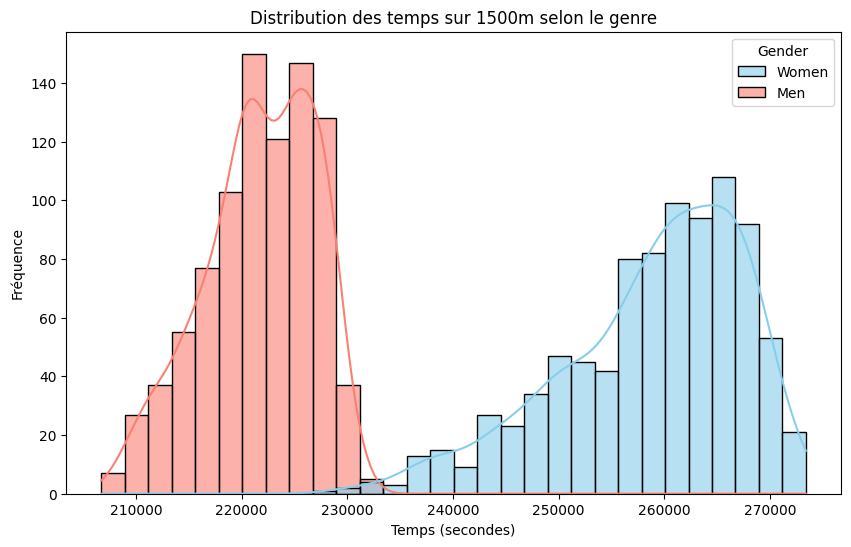

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_train,
    x="1500 Metres",
    hue="Gender",
    kde=True,
    bins=30,
    palette=["skyblue","salmon"],
    alpha=0.6
)

plt.title("Distribution des temps sur 1500m selon le genre")
plt.xlabel("Temps (secondes)")
plt.ylabel("Fréquence")
plt.show()


**Imputation et standartisation des données**

*Imputation*

On remarque la présence de valeurs NaN dans le jeu de données. Ces valeurs manquantes peuvent entraîner des problèmes lors de l’entraînement du modèle, puisque la majorité des algorithmes de Machine Learning ne peuvent pas les traiter directement. Afin d’éviter de supprimer des observations entières et ainsi perdre une quantité significative d’informations, j’ai choisi d’appliquer une stratégie d’imputation. Cette approche, couramment utilisée pour traiter les valeurs manquantes (Van der Loo & de Jonge, 2018), consiste à remplacer les valeurs absentes par des estimations calculées à partir des données disponibles. Dans mon cas, j’ai opté pour la médiane, car elle est moins sensible aux valeurs extrêmes que la moyenne (Géron, 2019). Cette méthode permet de conserver l’intégrité du jeu de données tout en le rendant exploitable pour l’entraînement du modèle, tout en limitant l’influence des valeurs aberrantes.

*Standartisation*

Finalement, la dernière étape du nettoyage des données consiste en la standardisation des variables. Cette étape est l’une des plus courantes en prétraitement de données, puisqu’une grande majorité des algorithmes de Machine Learning sont sensibles à la magnitude des variables (Géron, 2019). L’objectif est donc d’amener toutes les valeurs sur une même échelle afin de les rendre comparables, même si elles étaient initialement exprimées dans des unités différentes. Dans mon cas, certains temps étaient en centièmes de seconde tandis que d’autres étaient en secondes. Cette démarche s’inspire également des travaux de Hoffmann et al. (2017), qui ont appliqué une normalisation des temps de course dans leur modèle de prédiction en triathlon élite, afin de ramener toutes les performances sur une échelle commune avant l’entraînement.

Concrètement, les temps de course ont été centrés et réduits. Les valeurs représentent maintenant l’écart par rapport à la moyenne, exprimé en nombre d’écarts-types. Ainsi, une valeur de zéro est égale à la moyenne, une valeur positive indique une performance plus lente que la moyenne et dans le cas contraire, une valeur négative indique une performance plus rapide.


In [ ]:
#Séparation cible/features
y = df_train[col_cible]
X = df_train.drop(columns = [col_cible])

#Définition des colonnes numériques/catégorielles
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

#Pipelines de transformation
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='drop'
)

#Fite sur le train
X_train_t = imputer.fit_transform(X)
X_test_t = imputer.transform(df_test)

nom_cat = []
if len(cat_features) > 0:
  nom_cat = imputer.named_transformers_['cat']\
    .named_steps['onehot']\
    .get_feature_names_out(cat_features)

out_cols = num_features + list(nom_cat)

#Reconstruire des dataframe alignés
X_train_df = pd.DataFrame(X_train_t, columns=out_cols, index=X.index)
X_test_df = pd.DataFrame(X_test_t, columns=out_cols, index=df_test.index)

#Vérifier si les pipelines ont bien été appliqués
def count_nans(arr):
    if hasattr(arr, "isna"):
        return int(arr.isna().sum().sum())
    else:
        return int(np.isnan(arr).sum())

print("NaN dans X_train_df :", count_nans(X_train_df))
print("NaN dans X_test_df  :", count_nans(X_test_df))

print(X_train_df.shape)
X_train_df.head()

NaN dans X_train_df : 0
NaN dans X_test_df  : 0
(1788, 84)


,Age,1500 Metres Short Track,3000 Metres,800 Metres,Mile,Country_Algeria,Country_Argentina,Country_Armenia,Country_Athlete Refugee Team,Country_Australia,...,Country_Sweden,Country_Switzerland,Country_Türkiye,Country_Uganda,Country_Ukraine,Country_United States,Country_Uruguay,Country_Venezuela,Gender_Men,Gender_Women
0,0.000000,1.293382,1.063388,1.671339,2.706437,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.268494,-0.732391,-0.149945,-0.702692,-0.239684,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.126483,-1.574395,-1.605377,-1.244916,-1.437049,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.697488,-0.485937,-0.987085,-1.133585,-0.239684,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.697488,-0.163911,-0.720020,-0.786191,-0.785700,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### **Présentation des métriques**

J’ai choisi de présenter séparément les métriques d’évaluation et les algorithmes afin de rendre les explications plus claires. Dans mon projet, j’ai également implémenté une fonction qui regroupe l’ensemble des métriques retenues pour évaluer la performance des modèles. Chacune apporte un angle différent sur la qualité des prédictions :

*RMSE (Root Mean Squared Error):*

Cette métrique nous était imposée pour la compétition, mais elle demeure très pertinente pour l’évaluation du modèle. Elle fait partie des indicateurs classiques en régression, puisqu’elle pénalise davantage les grandes erreurs et exprime la dispersion des résidus dans les unités de la variable cible (Géron, 2019). De plus, elle est fréquemment utilisée comme métrique centrale de comparaison dans la littérature. On la retrouve notamment dans l’étude de Zhang et al. (2025) ainsi que dans celle de Hoffmann et al. (2017), où elle constitue une mesure de référence pour évaluer la performance des modèles.

*MSE (Mean Squared Error):*

L’erreur quadratique moyenne (MSE) mesure la moyenne des écarts au carré entre les valeurs prédites et les valeurs réelles (GeeksforGeeks, 2025). Elle est très proche du RMSE, mais ne prend pas la racine carrée des erreurs, ce qui la rend moins directement interprétable en unités de la variable cible. Néanmoins, elle demeure une métrique largement utilisée et figure comme indicateur principal dans l’étude de Zhang et al. (2025).

*MAE (Mean Absolute Error):*

L’erreur absolue moyenne correspond à la moyenne des écarts absolus entre les valeurs prédites et les valeurs réelles. Elle traite toutes les erreurs de manière linéaire et se montre donc plus robuste face aux valeurs extrêmes. Cet aspect est particulièrement pertinent dans le cadre de cette compétition, où l’unité de mesure génère des valeurs très élevées. L’étude de Zhang et al. (2025) utilise également le MAE comme indicateur pour quantifier l’erreur moyenne linéaire de ses modèles.

*MedAE (Median Absolute Error):*

La médiane de l’erreur absolue (MedAE) correspond à la médiane des écarts absolus entre les valeurs prédites et les valeurs réelles. Contrairement au MAE, qui calcule une moyenne, le MedAE met en avant l’erreur « typique » en ignorant l’influence des valeurs extrêmes. Cette métrique est donc particulièrement robuste, ce qui la rend intéressante à utiliser en complément du MAE pour évaluer les performances d’un modèle (Géron, 2019).

*R² (Coefficient de détermination):*

Le coefficient de détermination mesure la proportion de la variance de la variable cible qui est expliquée par le modèle. Plus le R² est proche de 1, meilleure est la capacité explicative du modèle.Dans leur étude sur la prédiction des performances en triathlon élite, Hoffmann et al. (2017) ont utilisé le R² pour évaluer aussi bien leurs modèles de régression multiple que leurs réseaux de neurones. Ce choix est particulièrement pertinent, puisqu’il s’agit du même type de défi que dans la compétition abordée ici : prédire avec précision des temps de course.

*MAPE (Mean Absolute Percentage Error):*

L’erreur absolue moyenne en pourcentage (MAPE) représente l’écart moyen entre les valeurs prédites et les valeurs réelles, exprimé en pourcentage des valeurs observées. Son principal avantage est son caractère intuitif : par exemple, un MAPE de 10 % signifie que les prédictions s’écartent en moyenne de 10 % des valeurs réelles. Dans l’étude de Zhang et al. (2025), le MAPE est utilisé en complément du RMSE, du MSE et du MAE afin de mesurer l’erreur relative et de comparer différentes approches de modélisation.

*SMAPE (Symmetric Mean Absolute Percentage Error):*

Souvent utilisée pour les prédictions de temps dans le domaine sportif, la métrique SMAPE calcule l’erreur en pourcentage de façon symétrique, ce qui permet une mesure plus stable et plus équilibrée que le MAPE. Elle constitue donc un bon complément à ce dernier. Dans l’article publié dans Applied Sciences (2025) sur la prédiction des performances olympiques, le SMAPE a été retenu pour évaluer la précision des modèles. Les auteurs rapportent un résultat particulièrement bas pour leur meilleur modèle, ce qui reflète une excellente qualité de prédiction.

In [ ]:
#Fonction pour définir les métriques
def metrique_reg(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  medae = median_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  smape = 100*np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

  return {
      'MSE': mse,
      'RMSE': rmse,
      'MAE': mae,
      'MedAE': medae,
      'R2': r2,
      'MAPE': mape,
      'SMAPE': smape
  }

### **Entrainement**


In [ ]:
#Vérifie si la variable résultat existe déjà sinon un dataframe est créé.
try:
    resultats
except NameError:
    resultats = pd.DataFrame()

# Fonction qui permet de garder à jour le tableau de visualisation (évite les doublons)
def upsert_result(store_df, algo_name, y_true, y_pred):
    row = metrique_reg(y_true, y_pred)
    row["Algorithm"] = algo_name
    new_row = pd.DataFrame([row])
    if store_df is None or store_df.empty or "Algorithm" not in store_df.columns:
        return new_row.reset_index(drop=True)
    store_df = store_df[store_df["Algorithm"] != algo_name]
    store_df = pd.concat([store_df, new_row], ignore_index=True)
    return store_df.reset_index(drop=True)

**Split train/validation**

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_df, y, test_size=0.2, random_state=42)

Pour le choix des algorithmes, j’ai consulté plusieurs études et projets similaires réalisés dans le cadre de compétitions comparables. Plusieurs modèles se sont distingués dans ces lectures. Même si certains étaient prévisiblement moins performants compte tenu de la nature du jeu de données, j’ai choisi de les inclure afin de disposer de points de comparaison pertinents avec des algorithmes plus efficaces. Comme rappelé à plusieurs reprises dans ce rapport, les algorithmes devaient convenir à une tâche de régression et, puisque les données étaient étiquetées, je me suis limitée à des approches supervisées. Le nombre d’algorithmes retenus était déjà bien suffisant pour assurer une évaluation complète et diversifiée.

**Régression Linéaire**

Comme modèle de base, j’ai décidé de débuter avec la régression linéaire. Un modèle qui permet de bien établir la relation linéaire entre les variables explicatives et la variable cible. Géron (2019) explique que la régression linéaire est souvent le point de départ pour la régression. C’est en autre le cas dans l’article Scientific Reports (2025) de Zhang et al., qui utilise la régression linéaire comme modèle de base pour ensuite le comparer à des modèles plus complexes.

Le plus grand avantage de ce modèle est sa simplicité, sa rapidité et sa facilité à interpréter. Toutefois, il ne capture pas très bien les relations non linéaire (Géron, 2019) et il est sensible aux outliers. Sa fonction de perte est entrainée avec le MSE qui a été expliqué plus haut.
En ce qui a trait aux hyperparamètres, j’ai utilisé l’implémentation de Scikit-Learn. Ce modèle comporte peu d’hyperparamètres. Le plus important est fit_intercept, qui permet de déterminer si le modèle doit calculer une ordonnée à l’origine ; dans mon cas, j’ai conservé la valeur par défaut (True). J’ai également gardé les autres paramètres (n_jobs=None, positive=False) à leurs valeurs par défaut, ce qui est habituel lorsque l’objectif est de construire un modèle de référence (baseline).

In [ ]:
linreg = LinearRegression()
linreg.fit(X_tr, y_tr)

#Modèle baseline : Régression Linéaire
y_val_pred_rl = linreg.predict(X_val)
score = metrique_reg(y_val, y_val_pred_rl)
for k, v in score.items():
  print(f"{k}: {v:.4f}" if isinstance(v, (float, np.floating)) else f"{k}: {v}")

#Prédiction sur le test
test_pred = linreg.predict(X_test_df)

resultats = upsert_result(resultats, "Régression Linéaire", y_val, y_val_pred_rl)

#Construction du fichier de soumission
submission = pd.DataFrame({'ID': range(len(test_pred)),
                           col_cible: test_pred})

submission_path = "submission_linear_regression.csv"
submission.to_csv('submission.csv', index=False)

MSE: 23406265.7718
RMSE: 4838.0023
MAE: 3643.5572
MedAE: 2771.3861
R2: 0.9402
MAPE: 1.4979
SMAPE: 1.4961


**Random Forest**

J’ai d’abord découvert l’utilisation de cet algorithme dans un projet disponible sur GitHub intitulé Predicting Olympic Outcomes with Python and Machine Learning (xbeat, 2015), qui applique une démarche structurée pour transformer les données sportives, entraîner des modèles de régression et évaluer leurs performances. Dans ce projet, le Random Forest est utilisé comme modèle d’entraînement. De plus, l’article publié dans Applied Sciences (2025) l’emploie également comme modèle de référence (baseline).

Le Random Forest est un algorithme ensembliste basé sur des arbres de décision, qui combine plusieurs arbres afin d’améliorer la robustesse et de réduire le risque de surapprentissage. Contrairement à la régression linéaire, il capture efficacement les relations non linéaires et se montre robuste face aux valeurs extrêmes. Un autre avantage est qu’il nécessite peu de prétraitement. Toutefois, il présente certains désavantages : il est plus long à entraîner et reste moins interprétable que des modèles plus simples. L’algorithme a été entraîné en minimisant la
fonction de perte MSE, critère par défaut pour les tâches de régression dans les arbres de décision et leurs variantes ensemblistes.

Les hyperparamètres ont été sélectionnés de manière empirique, en testant différentes configurations afin de trouver une combinaison offrant de bonnes performances sans surapprentissage. Par exemple, le paramètre n_estimators a été fixé à 600 pour assurer une bonne stabilité des résultats, tandis que max_features="sqrt" a été choisi pour réduire la corrélation entre les arbres. Les paramètres min_samples_split et min_samples_leaf ont été conservés à leurs valeurs par défaut, qui se sont révélées suffisantes dans ce contexte. Enfin, random_state a été défini afin d’assurer la reproductibilité des expériences.

In [ ]:
#Random Forest hyperparamètre
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_tr, y_tr)


y_val_pred_rf= rf.predict(X_val)
scores = metrique_reg(y_val, y_val_pred_rf)
for k, v in scores.items():
    try:
        print(f"{k}: {v:.4f}")
    except:
        print(f"{k}: {v}")


importances = pd.Series(rf.feature_importances_, index=X_train_df.columns).sort_values(ascending=False)


rf.fit(X_train_df, y)


test_pred = rf.predict(X_test_df)

resultats = upsert_result(resultats, "Random Forest", y_val, y_val_pred_rf)

submission = pd.DataFrame({
    "ID": range(len(test_pred)),
    col_cible: test_pred
})
submission_path = "submission_random_forest.csv"
submission.to_csv(submission_path, index=False)

MSE: 9256095.0030
RMSE: 3042.3831
MAE: 2286.3898
MedAE: 1806.2792
R2: 0.9763
MAPE: 0.9513
SMAPE: 0.9499


**Gradient Boosting**

Dans une suite logique, j’ai décidé d’intégrer Gradient Boosting dans ma liste d’algorithmes à tester. Géron (2019) décrit cet algorithme comme une évolution des arbres de décision, qui combine des modèles faibles de façon séquentielle afin de réduire l’erreur résiduelle. Il était donc naturel de l’inclure dans mon projet. De plus, l’article de Scientific Reports (2025) de Zhang et al. montre que le Gradient Boosting atteint de très bonnes performances, ce qui justifie son utilisation dans des projets de prédiction sportive.

Le Gradient Boosting, tout comme le Random Forest, est un algorithme ensembliste basé sur des arbres de décision. Toutefois, il construit les arbres de manière séquentielle, chaque nouvel arbre cherchant à corriger les erreurs du précédent. Cette approche le rend particulièrement performant, souvent supérieur à des modèles plus simples comme la régression linéaire ou même le Random Forest. Il capture efficacement les relations non linéaires ainsi que les interactions entre variables. Son principal avantage est sa flexibilité grâce à de nombreux hyperparamètres ajustables, permettant de bien contrôler le biais et la variance. Cependant, cela le rend également plus long à entraîner, plus sensible au réglage des paramètres et donc plus susceptible au surapprentissage. Il est également moins interprétable qu’un arbre de décision simple. Par défaut, le Gradient Boosting minimise l’erreur quadratique moyenne (MSE) en régression.

Les hyperparamètres ont été sélectionnés de manière empirique. J’ai privilégié un faible learning_rate (0,05) couplé à un nombre d’arbres élevé (n_estimators=500) pour stabiliser l’apprentissage, des arbres peu profonds (max_depth=4) pour limiter la variance, ainsi qu’un sous-échantillonnage (subsample=0,9) et max_features="sqrt" afin de réduire la corrélation entre arbres et limiter le surapprentissage. Enfin, la fonction de perte squared_error a été utilisée, ce qui aligne l’optimisation du modèle sur les métriques MSE/RMSE employées pour l’évaluation.

MSE: 8992128.3551
RMSE: 2998.6878
MAE: 2269.4067
MedAE: 1765.4066
R2: 0.9770
MAPE: 0.9441
SMAPE: 0.9430


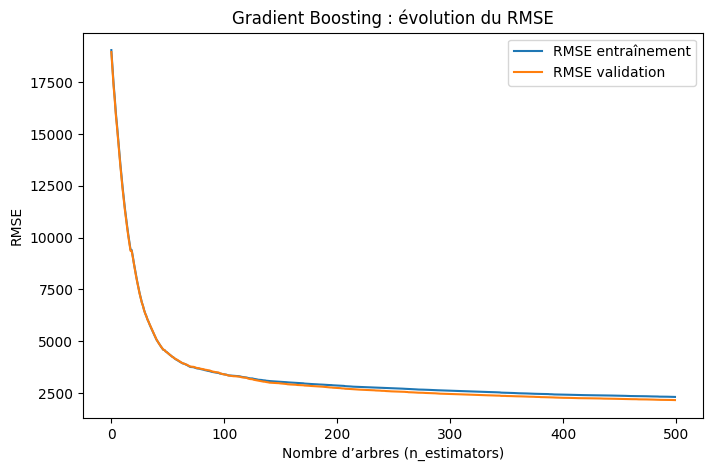

In [ ]:
#Gradient Boosting hyperparamètres
gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    n_estimators=500,
    max_depth=4,
    subsample=0.9,
    max_features="sqrt",
    random_state=42
)

gbr.fit(X_tr, y_tr)

y_val_pred_gb = gbr.predict(X_val)
scores = metrique_reg(y_val, y_val_pred_gb)
for k, v in scores.items():
    try:
        print(f"{k}: {v:.4f}")
    except:
        print(f"{k}: {v}")


gbr.fit(X_train_df, y)


test_pred = gbr.predict(X_test_df)

resultats = upsert_result(resultats, "Gradient Boosting", y_val, y_val_pred_gb)

submission = pd.DataFrame({
    "ID": range(len(test_pred)),
    col_cible: test_pred
})
submission.to_csv("submission_gradient_boosting.csv", index=False)

# Courbes RMSE par étape du boosting
train_rmse, val_rmse = [], []
for y_tr_pred, y_va_pred in zip(gbr.staged_predict(X_tr), gbr.staged_predict(X_val)):
    train_rmse.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, y_va_pred)))

x = np.arange(1, gbr.n_estimators + 1)


# Visualisation
plt.figure(figsize=(8,5))
plt.plot(train_rmse, label="RMSE entraînement")
plt.plot(val_rmse, label="RMSE validation")
plt.xlabel("Nombre d’arbres (n_estimators)")
plt.ylabel("RMSE")
plt.title("Gradient Boosting : évolution du RMSE")
plt.legend()
plt.show()

**Évaluation de la généralisation (CV RMSE) : Gradient Boosting vs Random Forest**

In [ ]:
def cv_rmse(model, X, y, n_splits=5, seed=42):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    neg_rmse = cross_val_score(model, X, y,
                               scoring="neg_root_mean_squared_error",
                               cv=cv, n_jobs=-1)
    rmse = -neg_rmse
    return rmse.mean(), rmse.std()


# Modèles
gbr = GradientBoostingRegressor(
    loss="squared_error", learning_rate=0.05, n_estimators=500,
    max_depth=4, subsample=0.9, max_features="sqrt", random_state=42
)

rf = RandomForestRegressor(
    n_estimators=800, max_depth=None, min_samples_split=2,
    min_samples_leaf=1, max_features="sqrt", n_jobs=-1, random_state=42
)

for name, mdl in [("GBR", gbr), ("RF", rf)]:
    m, s = cv_rmse(mdl, X_train_df, y, n_splits=5)
    print(f"{name} CV RMSE: {m:.2f} ± {s:.2f}")

GBR CV RMSE: 3278.11 ± 114.39
RF CV RMSE: 3135.82 ± 63.26


**k-nearest neighbors**

Géron (2019) présente le k-NN comme un modèle non paramétrique simple, qui prédit en fonction de la proximité des exemples d’entraînement. Cet algorithme est également présent dans l’article de Scientific Reports (2025) de Zhang et al., où il obtient des résultats moins performants que d’autres modèles plus complexes, mais reste pertinent comme algorithme de comparaison.

Le principe du k-NN est de prédire la valeur d’une nouvelle instance en recherchant les k points les plus proches dans l’espace des caractéristiques, puis en retournant la moyenne de leurs valeurs cibles. Ses principaux avantages sont sa simplicité d’implémentation et sa capacité à capturer des relations non linéaires locales. En revanche, il présente plusieurs limites : il est sensible à l’échelle des variables (ce qui justifie l’étape de standardisation effectuée au préalable), il perd en efficacité sur des jeux de données comportant un grand nombre de dimensions (curse of dimensionality), et son temps de prédiction devient coûteux lorsque le volume de données est important, puisqu’il faut comparer chaque nouvelle instance à l’ensemble du jeu d’entraînement. Le k-NN n’ayant pas de fonction de perte explicite (puisqu’il ne comporte pas de phase d’entraînement à proprement parler), ses performances sont évaluées uniquement au moyen des métriques de régression choisies (MSE, RMSE, MAE, etc.).

Concernant les hyperparamètres, le modèle K-NN a d’abord été fixé de manière empirique avec k=5k=5k=5, weights="distance" et une distance euclidienne (p=2). Par la suite, un tuning systématique a été effectué à l’aide de GridSearchCV, en explorant plusieurs combinaisons de n_neighbors (3 à 21), de pondération (uniform et distance) et de métriques de distance (p=1 et p=2). Le meilleur modèle a été sélectionné sur la base de la validation croisée avec la métrique MAE, ce qui a permis d’obtenir un compromis optimal entre biais et variance.

In [ ]:
#K-NN baseline
knn = KNeighborsRegressor(n_neighbors=5, weights="distance", p=2, n_jobs=-1)
knn.fit(X_tr, y_tr)


y_val_pred_knn = knn.predict(X_val)
scores = metrique_reg(y_val, y_val_pred_knn)
for k, v in scores.items():
    try: print(f"{k}: {v:.4f}")
    except: print(f"{k}: {v}")


param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1: manhattan_distance, 2: euclidean_distance
}
gs = GridSearchCV(
    KNeighborsRegressor(n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)
# K-NN tuning
print('\nk-nearest neighbors avec tuning')
gs.fit(X_tr, y_tr)
print("Best params:", gs.best_params_, " | best CV MAE:", -gs.best_score_)

best_knn = gs.best_estimator_
y_val_pred_knn_tuned = best_knn.predict(X_val)
for k, v in metrique_reg(y_val, y_val_pred_knn_tuned).items():
    try: print(f"{k}: {v:.4f}")
    except: print(f"{k}: {v}")

resultats = upsert_result(resultats, "k-nearest neighbors", y_val, y_val_pred_knn_tuned)

submission = pd.DataFrame({
    "ID": range(len(test_pred)),
    col_cible: test_pred
})
submission.to_csv("submission_KNeighbors.csv", index=False)

MSE: 17004402.7576
RMSE: 4123.6395
MAE: 2994.0161
MedAE: 2123.7847
R2: 0.9566
MAPE: 1.2435
SMAPE: 1.2413

k-nearest neighbors avec tuning
Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best params: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}  | best CV MAE: 2889.238816201876
MSE: 13882463.7424
RMSE: 3725.9178
MAE: 2778.2882
MedAE: 2106.1056
R2: 0.9645
MAPE: 1.1563
SMAPE: 1.1532


**SVR avec RBF**

Le SVR est particulièrement puissant pour capturer des relations non linéaires lorsqu’il est associé à des noyaux tels que le RBF (Radial Basis Function) (Géron, 2019). Il figure d’ailleurs parmi les modèles les plus performants dans l’étude de Zhang et al. (2025) publiée dans Scientific Reports, ce qui confirme sa pertinence dans le cadre de ce projet.

Le SVR est une extension des machines à vecteurs de support (SVM) adaptée à la régression. Son principe est de trouver une fonction qui approxime au mieux les données tout en tolérant une certaine marge d’erreur. Le noyau RBF permet de projeter les données dans un espace de dimension plus élevée afin de capturer des relations non linéaires complexes. Parmi ses avantages, on retrouve sa robustesse, son efficacité sur des jeux de données de petite à moyenne taille et sa capacité à fournir d’excellentes performances lorsqu’il est correctement régularisé. En revanche, il présente certains inconvénients : un temps de calcul élevé sur des jeux de données volumineux, une forte sensibilité aux hyperparamètres et une interprétabilité limitée par rapport aux modèles linéaires ou aux arbres de décision. Le SVR utilise une fonction de perte de type epsilon-insensitive loss, où les erreurs inférieures au seuil ε ne sont pas pénalisées.

Dans ce projet, j’ai d’abord utilisé un paramétrage de base (C=100, epsilon=0,1, gamma="scale") afin d’obtenir un modèle non linéaire raisonnablement régularisé. Le paramètre C contrôle le compromis biais–variance (des valeurs élevées favorisent l’ajustement au détriment de la généralisation), ε fixe la tolérance aux petites erreurs et gamma détermine l’influence locale des observations dans l’espace du noyau.

J’ai ensuite procédé à un tuning systématique par validation croisée (GridSearchCV), en explorant C {1, 10, 100, 500}, epsilon {0,01, 0,1, 0,5, 1,0} et gamma {"scale","auto"}, avec la MAE comme critère de sélection. Ce protocole m’a permis d’identifier une configuration offrant un meilleur compromis entre biais et variance, tout en restant robuste face aux valeurs extrêmes.

In [ ]:
#SVR baseline
svr = SVR(kernel="rbf", C=100.0, epsilon=0.1, gamma="scale")
svr.fit(X_tr, y_tr)

y_val_pred_svr = svr.predict(X_val)
print("SVR RBF (baseline)")
for k, v in metrique_reg(y_val, y_val_pred_svr).items():
    try: print(f"{k}: {v:.4f}")
    except: print(f"{k}: {v}")

#SVR tuning
param_grid_svr = {
    "C": [1, 10, 100, 500],
    "epsilon": [0.01, 0.1, 0.5, 1.0],
    "gamma": ["scale", "auto"]
}
gs = GridSearchCV(
    SVR(kernel="rbf"),
    param_grid=param_grid_svr,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)
gs.fit(X_tr, y_tr)
print("\nBest params:", gs.best_params_)

best_svr = gs.best_estimator_
y_val_pred_svr_tuned = best_svr.predict(X_val)

print("\n SVR RBF (tuned)")
for k, v in metrique_reg(y_val, y_val_pred_svr_tuned).items():
    try: print(f"{k}: {v:.4f}")
    except: print(f"{k}: {v}")

resultats = upsert_result(resultats, "SVR RBF", y_val, y_val_pred_svr_tuned)

best_svr.fit(X_train_df, y)
test_pred = best_svr.predict(X_test_df)
submission = pd.DataFrame({"ID": range(len(test_pred)), col_cible: test_pred})
submission.to_csv("submission_svr.csv", index=False)

=== SVR RBF (baseline) ===
MSE: 77448097.1406
RMSE: 8800.4601
MAE: 6818.1786
MedAE: 5299.1794
R2: 0.8021
MAPE: 2.8131
SMAPE: 2.8175
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best params: {'C': 500, 'epsilon': 0.01, 'gamma': 'scale'}

 SVR RBF (tuned)
MSE: 34675596.7035
RMSE: 5888.5989
MAE: 4328.7895
MedAE: 3126.1549
R2: 0.9114
MAPE: 1.7978
SMAPE: 1.7949


**Arbre de décision**

Les arbres de décision sont des modèles intuitifs, faciles à interpréter et capables de gérer des relations non linéaires sans nécessiter de mise à l’échelle des données (Géron, 2019). Cet algorithme est également cité dans l’article de Scientific Reports (2025). Bien que ses résultats y soient plus modestes que ceux d’approches plus avancées, il demeure un modèle intéressant à inclure pour des fins de comparaison.

Un arbre de décision segmente l’espace des caractéristiques en sous-régions homogènes. Chaque division est choisie afin de minimiser MSE dans les sous-ensembles. La prédiction d’une feuille correspond à la moyenne des valeurs cibles des échantillons qui y appartiennent. Ce fonctionnement le rend à la fois facile à visualiser et à interpréter, tout en lui permettant de modéliser des relations non linéaires et des interactions entre variables. De plus, il est peu sensible au prétraitement. Toutefois, il présente plusieurs désavantages : une tendance marquée au surapprentissage si aucune régularisation n’est appliquée, une instabilité face à de légères variations dans les données, et des performances généralement inférieures aux méthodes ensemblistes comme le Random Forest ou le Gradient Boosting.

Les hyperparamètres de l’arbre de décision ont été sélectionnés de manière empirique à l’aide d’une validation croisée (GridSearchCV). La recherche a porté sur la profondeur maximale (max_depth) ainsi que sur les seuils de régularisation (min_samples_split et min_samples_leaf). Cette démarche a permis de contrôler la complexité du modèle et de limiter le surapprentissage, tout en maintenant un pouvoir prédictif satisfaisant.

In [ ]:
# Decision Tree baseline
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_tr, y_tr)

y_val_pred_dt = dt.predict(X_val)
scores_dt = metrique_reg(y_val, y_val_pred_dt)

print("\nArbre de décision (baseline)")
for k, v in scores_dt.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")

# Decision Tree tuning
param_grid_dt = {
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10]
}
gs_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)
gs_dt.fit(X_tr, y_tr)
print('\nBest params (Decision Tree):', gs_dt.best_params_)
best_dt = gs_dt.best_estimator_

y_val_pred_dt_tuned = best_dt.predict(X_val)
scores_dt_tuned = metrique_reg(y_val, y_val_pred_dt_tuned)

print("\nDecision Tree (tuned)")
for k, v in scores_dt_tuned.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")

resultats = upsert_result(resultats, "Decision Tree", y_val, y_val_pred_dt_tuned)

best_dt.fit(X_train_df, y)
test_pred_dt = best_dt.predict(X_test_df)
submission_dt = pd.DataFrame({"ID": X_test_df.index, col_cible: test_pred_dt})
submission_dt.to_csv("submission_decision_tree.csv", index=False)


=== Arbre de décision (baseline) ===
MSE: 15518256.5838
RMSE: 3939.3218
MAE: 3023.5335
MedAE: 2194.5000
R2: 0.9603
MAPE: 1.2516
SMAPE: 1.2525
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best params (Decision Tree): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

=== Decision Tree (tuned) ===
MSE: 13155119.1460
RMSE: 3626.9986
MAE: 2804.9679
MedAE: 2237.4167
R2: 0.9664
MAPE: 1.1609
SMAPE: 1.1620


**Réseau de neuronnes**

On arrive enfin au dernier algorithme testé dans ce projet : le réseau de neurones. Géron (2019) explique que le réseau de neurones multi-couches (MLP) est particulièrement puissant pour modéliser des relations non linéaires complexes grâce à l’empilement de couches et à l’utilisation de fonctions d’activation. Dans l’étude sur la prédiction des performances en triathlon élite (Hoffmann et al., 2017), les auteurs comparent une régression multiple et un réseau de neurones. Leurs résultats montrent que le réseau de neurones capture mieux la complexité des données, ce qui justifie sa place dans mon projet.

Un réseau de neurones est composé d’une couche d’entrée, d’une ou plusieurs couches cachées et d’une couche de sortie. Chaque neurone applique une transformation linéaire suivie d’une fonction d’activation (souvent ReLU ou tanh), ce qui permet au modèle de capturer des relations non linéaires. Ses principaux avantages résident dans sa flexibilité architecturale et sa capacité à traiter des données riches et complexes. Cependant, il est très couteux en termes de ressources et nécessit
une grande quantité de données pour bien généraliser. Il est plus susceptible au surapprentissage si le nombre donné est insuffisant. Par défaut, le réseau de neurones minimise l’erreur quadratique moyenne (MSE) pour les tâches de régression.

Dans ce projet, j’ai retenu une architecture composée de deux couches cachées denses de 128 et 64 neurones, chacune activée par la fonction ReLU. Ce choix permet de capturer efficacement les relations non linéaires tout en maintenant une complexité raisonnable. La couche de sortie comprend un seul neurone adapté à la régression. Le modèle a été entraîné avec l’optimiseur Adam, un algorithme de descente de gradient adaptative performant, et un taux d’apprentissage fixé à 0,0005, choisi empiriquement pour stabiliser l’entraînement. La fonction de perte utilisée est le MSE, et la MAE a été suivie comme métrique complémentaire. Afin de limiter le surapprentissage, un mécanisme d’early stopping a été appliqué avec une patience de 15 époques, ce qui permet d’arrêter l’entraînement si la performance sur l’ensemble de validation cesse de s’améliorer. Enfin, un batch_size de 256 et un maximum de 200 époques ont été définis, ce qui constitue un compromis entre vitesse de convergence et stabilité du modèle.

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 1.5507 - mae: 1.0046 - val_loss: 0.8748 - val_mae: 0.8035
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8500 - mae: 0.7771 - val_loss: 0.6876 - val_mae: 0.6334
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6087 - mae: 0.6194 - val_loss: 0.3902 - val_mae: 0.4712
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.3434 - mae: 0.4478 - val_loss: 0.2360 - val_mae: 0.3716
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2205 - mae: 0.3641 - val_loss: 0.1773 - val_mae: 0.3100
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1514 - mae: 0.2962 - val_loss: 0.1611 - val_mae: 0.2889
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1299 - mae: 0.2682 - val_loss: 0.1488 - val_mae: 0.2854
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1051 - mae: 0.2477 - val_loss: 0.1165 - val_mae: 0.2617
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1015 - mae: 

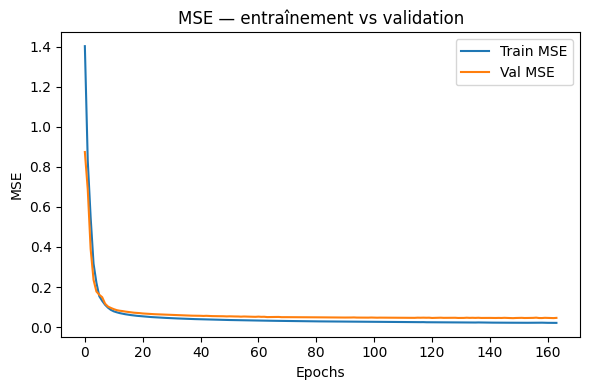

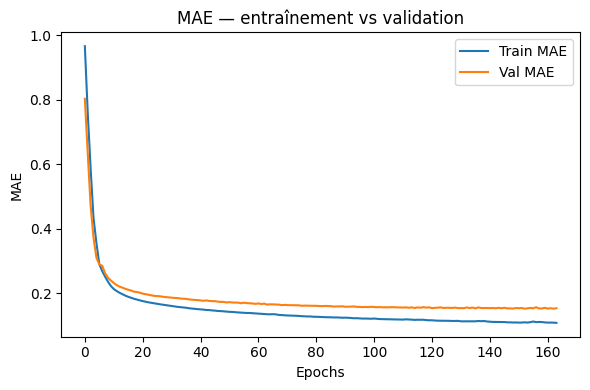

In [ ]:
x_scaler = StandardScaler()
X_tr_scaled  = x_scaler.fit_transform(X_tr)
X_val_scaled = x_scaler.transform(X_val)
X_test_scaled = x_scaler.transform(X_test_df)


y_scaler = StandardScaler()
y_tr_s   = y_scaler.fit_transform(y_tr.values.reshape(-1,1)).ravel()
y_val_s  = y_scaler.transform(y_val.values.reshape(-1,1)).ravel()


model = keras.Sequential([
    keras.Input(shape=(X_tr_scaled.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])


early = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)


history = model.fit(
    X_tr_scaled, y_tr_s,
    validation_data=(X_val_scaled, y_val_s),
    epochs=200, batch_size=256, callbacks=[early], verbose=1
)


y_val_pred_s = model.predict(X_val_scaled).ravel()
y_val_pred_rn   = y_scaler.inverse_transform(y_val_pred_s.reshape(-1,1)).ravel()


scores = metrique_reg(y_val, y_val_pred_rn)
for k, v in scores.items():
    try: print(f"{k}: {v:.4f}")
    except: print(f"{k}: {v}")


y_test_pred_s = model.predict(X_test_scaled).ravel()
test_pred     = y_scaler.inverse_transform(y_test_pred_s.reshape(-1,1)).ravel()

resultats = upsert_result(resultats, "Réseau de neuronne", y_val, y_val_pred_rn)


submission = pd.DataFrame({
    "ID": range(len(test_pred)),
    col_cible: test_pred
})
submission_path = "submission_reseau_neuronne.csv"
submission.to_csv(submission_path, index=False)

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE — entraînement vs validation")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE — entraînement vs validation")
plt.legend()
plt.tight_layout()
plt.show()

### **Visualisation des données**

**Tableau résultats des métriques**

In [ ]:
resultats = (
    resultats
    .drop_duplicates(subset=["Algorithm"], keep="last")
    .reset_index(drop=True)
)

if "RMSE" in resultats.columns:
    resultats = resultats.sort_values("RMSE").reset_index(drop=True)

cols = ["Algorithm"] + [c for c in resultats.columns if c != "Algorithm"]
resultats = resultats[cols].copy()

style_css = """
<style>
table.dataframe {border-collapse: collapse; width: 100%; color: #EDF6F9; font-size: 14px;}
table.dataframe th, table.dataframe td {border: 1px solid #181B33; padding: 6px 8px; text-align: center;}
table.dataframe th {background-color: #88B0B0; color:#006D77;}
table.dataframe  {background-color: #88B0B0;}
table.dataframe caption { caption-side: top; font-size: 1.1em; font-weight: bold; padding: 6px; color: #EDF6F9; }
table.dataframe tbody tr:hover {background-color: #83C5BE !important; color: #006D77 !important; cursor: pointer;}
table.dataframe tbody tr:nth-child(odd) {background-color: #006D77;}
</style>
"""
from IPython.display import HTML, display
html_tbl = (
    resultats.style
      .set_table_attributes('class="dataframe"')
      .format({c: "{:.4f}" for c in resultats.columns if pd.api.types.is_numeric_dtype(resultats[c])})
      .set_caption("Résultats Métriques")
      .to_html()
)
display(HTML(style_css + html_tbl))

,Algorithm,MSE,RMSE,MAE,MedAE,R2,MAPE,SMAPE
0,Gradient Boosting,8992128.3551,2998.6878,2269.4067,1765.4066,0.9770,0.9441,0.9430
1,Random Forest,9256095.0030,3042.3831,2286.3898,1806.2792,0.9763,0.9513,0.9499
2,Decision Tree,13155119.1460,3626.9986,2804.9679,2237.4167,0.9664,1.1609,1.1620
3,k-nearest neighbors,13882463.7424,3725.9178,2778.2882,2106.1056,0.9645,1.1563,1.1532
4,Réseau de neuronne,17568248.0000,4191.4494,3029.5608,2135.6406,0.9551,1.2493,1.2479
5,Régression Linéaire,23406265.7718,4838.0023,3643.5572,2771.3861,0.9402,1.4979,1.4961
6,SVR RBF,34675596.7035,5888.5989,4328.7895,3126.1549,0.9114,1.7978,1.7949


**Visualisation sous forme de nuage**




/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


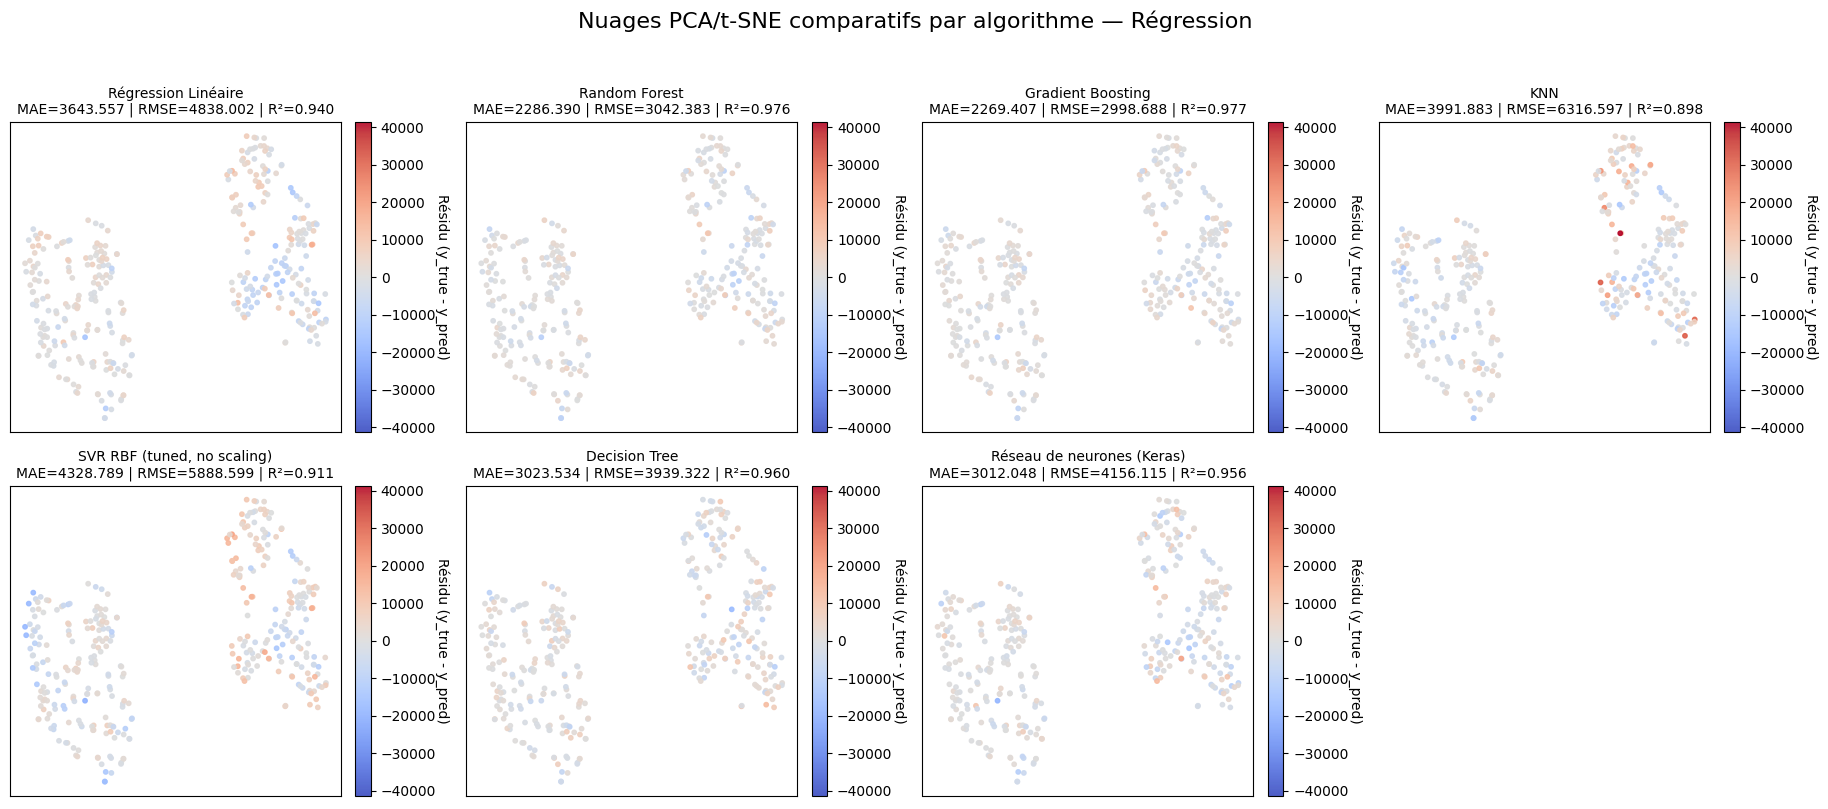

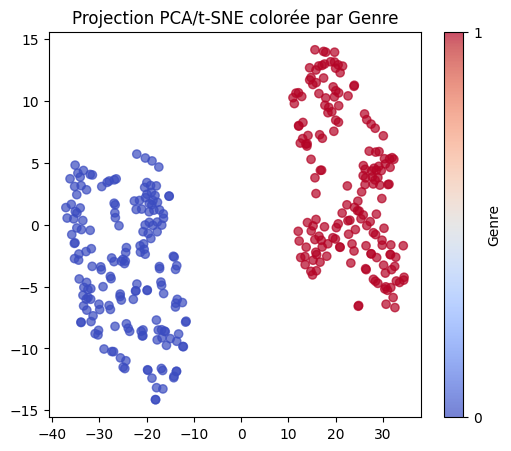

In [ ]:
def build_model(n_features):
    model = keras.Sequential([
        keras.Input(shape=(n_features,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  loss="mse", metrics=["mae"])
    return model

early = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)


keras_base = KerasRegressor(
    model=build_model,
    model__n_features=X_tr.shape[1],
    epochs=200,
    batch_size=256,
    callbacks=[early],
    verbose=0
)


keras_pipe = Pipeline([
    ("x_scaler", StandardScaler()),
    ("reg_y_scaled", TransformedTargetRegressor(
        regressor=keras_base,
        transformer=StandardScaler()
    ))
])



def compute_embedding(X, pca_dim=50, perplexity=30, random_state=42):
    pca = PCA(n_components=min(pca_dim, X.shape[1]), random_state=random_state)
    X_red = pca.fit_transform(X)
    X_2d = TSNE(
        n_components=2, perplexity=perplexity, learning_rate="auto",
        init="pca", random_state=random_state, n_iter=1000
    ).fit_transform(X_red)
    return X_2d


def plot_regressors_comparison(models, X_tr, y_tr, X_val, y_val,
                               color_mode="residuals",
                               ncols=4,
                               title="Nuages PCA/t-SNE comparatifs — Régression"):
    X2d = compute_embedding(X_val)

    n = len(models)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.6*ncols, 4.1*nrows), squeeze=False)
    fig.suptitle(title, fontsize=16)

    cache = []
    all_res = []
    for name, model in models:
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        m = metrique_reg(y_val, y_pred)
        cache.append((name, model, y_pred, m))
        if color_mode == "residuals":
            all_res.append(y_val - y_pred)

    vmin = vmax = None
    if color_mode == "residuals":
        all_res = np.concatenate(all_res)
        mabs = np.nanmax(np.abs(all_res))
        vmin, vmax = -mabs, mabs

    for i, (name, model, y_pred, m) in enumerate(cache):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        if color_mode == "residuals":
            colors = (y_val - y_pred)
            cmap = "coolwarm"
            cbar_label = "Résidu (y_true - y_pred)"
        elif color_mode == "y_true":
            colors = y_val
            cmap = "viridis"
            cbar_label = "y_true"
        else:
            colors = y_pred
            cmap = "viridis"
            cbar_label = "y_pred"

        sc = ax.scatter(X2d[:, 0], X2d[:, 1], c=colors, s=10, alpha=0.9,
                        cmap=cmap, vmin=vmin, vmax=vmax)

        mae = m.get("MAE", np.nan)
        rmse = m.get("RMSE", np.nan)
        r2 = m.get("R2", np.nan)
        ax.set_title(f"{name}\nMAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}", fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])

        cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(cbar_label, rotation=270, labelpad=10)

    for j in range(len(cache), nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



models_reg = [
    ("Régression Linéaire", LinearRegression()),
    ("Random Forest", RandomForestRegressor(
        n_estimators=600, max_depth=None, min_samples_split=2,
        min_samples_leaf=1, max_features="sqrt", n_jobs=-1, random_state=42
    )),
    ("Gradient Boosting", GradientBoostingRegressor(
        loss="squared_error", learning_rate=0.05, n_estimators=500,
        max_depth=4, subsample=0.9, max_features="sqrt", random_state=42
    )),
    ("KNN", Pipeline([("scaler", StandardScaler()),
                      ("reg", KNeighborsRegressor(n_neighbors=5, weights="distance", p=2))])),
    ("SVR RBF (tuned, no scaling)", (best_svr)),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Réseau de neurones (Keras)", keras_pipe),
]


plot_regressors_comparison(
    models_reg,
    X_tr, y_tr, X_val, y_val,
    color_mode="residuals",
    ncols=4,
    title="Nuages PCA/t-SNE comparatifs par algorithme — Régression"
)
plt.figure(figsize=(6,5))

# convertir en 0/1 pour "Men"/"Women"
colors = (y_val.index.map(lambda i: 1 if df_train.loc[i, "Gender"]=="Women" else 0))

# scatter avec une palette
sc = plt.scatter(X2d[:,0], X2d[:,1], c=colors, cmap="coolwarm", alpha=0.7)

plt.title("Projection PCA/t-SNE colorée par Genre")
plt.colorbar(sc, ticks=[0,1], label="Genre")
plt.show()

### **Explication des résultats**

La partie résultat sera séparé en deux. Dans la première partie, j’aborderai les résultats en générales et pourquoi certains algorithmes ont mieux performé que d’autres. Dans la deuxième partie, il sera question de départager deux algorithmes qui ont obtenus des résultats similaires et déterminer lequel est en réalité le plus performant pour le jeu de données.

**Évaluation de l’ensemble des algorithmes :**

Pour la visualisation des performances des algorithmes, j’ai choisi de présenter un tableau récapitulatif des principales métriques (RMSE, MAE, R², etc.), complété par des nuages PCA/t-SNE colorés par résidus. Cette double approche permet à la fois une comparaison quantitative précise et une interprétation visuelle de la qualité de généralisation des différents modèles.
Le tableau récapitulatif présente les résultats obtenus pour les différentes métriques en fonction des algorithmes testés. Ces indicateurs permettent de comparer la précision et la capacité de généralisation des modèles. Le tableau a été programmé pour afficher les meilleurs résultats en haut et les moins performants vers le bas, ce qui facilite la lecture comparative.

Sans grande surprise, l’algorithme de régression linéaire se situe parmi les moins performants. Ce choix avait été fait à titre de comparaison, sachant que ce modèle ne capture pas les relations non linéaires entre les variables. Toutefois, ses résultats ne sont pas catastrophiques : il atteint un R² d’environ 0,94 et un RMSE de 4838, ce qui demeure acceptable pour un modèle de base.

Le modèle le moins performant dans ce contexte est toutefois le SVR avec noyau RBF. Alors que Zhang et al. (2025) rapportent des performances élevées de cet algorithme dans leur étude, mes résultats montrent au contraire une capacité explicative plus faible (R² ≈ 0,91) et un RMSE plus élevé (5888). Cette divergence peut s’expliquer par la nature du jeu de données : le SVR est particulièrement sensible à la taille et à l’homogénéité des données ainsi qu’au choix des hyperparamètres (C, epsilon, gamma). Or, la compétition repose sur un jeu de données plus petit et plus hétérogène, ce qui limite la stabilité et la performance du modèle.

Un raisonnement semblable peut être appliqué au réseau de neurones. Malgré une architecture adaptée et un tuning rigoureux, ce type de modèle demeure exigeant et donne de meilleurs résultats sur des jeux de données volumineux. Comme prévu, ses résultats sont intermédiaires : un R² d’environ 0,95 et un RMSE de 4191. Ils ne rivalisent pas avec les modèles ensemblistes, mais restent supérieurs à ceux de la régression linéaire et du SVR.

Pour ce qui est du k-nearest neighbors (k-NN) et de l’arbre de décision, ils se situent dans le groupe intermédiaire. Le KNN atteint un R² d’environ 0,96 et un RMSE de 3725, ce qui en fait un modèle plus précis que la régression linéaire, le SVR et même le réseau de neurones. Toutefois, il reste en retrait par rapport aux modèles ensemblistes. L’arbre de décision présente une performance comparable, avec une bonne capacité à capter les relations non linéaires, mais une tendance au surapprentissage qui limite sa généralisation. Ces deux modèles constituent donc des points de comparaison intéressants, mais ils ne rivalisent pas avec les algorithmes ensemblistes.

En complément du tableau des métriques, j’ai choisi d’incorporer une visualisation des résidus des modèles à l’aide de nuages obtenus par une réduction de dimension PCA/t-SNE. Ces représentations permettent d’évaluer la répartition spatiale des erreurs et de détecter si un algorithme a tendance à produire des erreurs systématiques dans certaines régions du jeu de données.

L’objectif recherché est d’observer des résultats dont les résidus tendent vers zéro, représentés par des couleurs neutres. Or, pour des algorithmes comme la régression linéaire et le k-NN, on observe des zones marquées par des résidus systématiquement élevés (rouge ou bleu vif), ce qui illustre leurs limites. Le SVR et le réseau de neurones présentent des résidus plus diffus mais toujours visibles, ce qui les situe dans une performance intermédiaire. Enfin, l’arbre de décision révèle une tendance au surapprentissage, avec des zones locales très contrastées où les erreurs sont fortement accentuées.

**Les algorithmes les plus performants :**

Jusqu’à présent, je n’ai pas abordé les résultats des algorithmes les plus performants, et ce de manière volontaire. En effet, deux modèles en particulier, Random Forest et Gradient Boosting, se sont démarqués en obtenant les meilleurs résultats dans l’ensemble des métriques. Pour Random Forest, le R² atteint environ 0,9763 avec un RMSE de 3042, tandis que Gradient Boosting obtient un R² de 0,9770 et un RMSE de 2998. Des performances très proches, auxquelles s’ajoutent des valeurs de MAE et MedAE parmi les plus faibles, confirmant la précision et la robustesse de leurs prédictions. Enfin, leurs MAPE et SMAPE se maintiennent à des niveaux bas, indiquant que les erreurs relatives exprimées en pourcentage demeurent limitées et stables. Ces résultats rejoignent d’ailleurs ceux de Zhang et al. (2025), qui soulignent l’efficacité de ces méthodes dans la prédiction de performances sportives.

Les visualisations par nuages résiduels confirment ces observations : contrairement aux modèles plus simples ou intermédiaires, Random Forest et Gradient Boosting présentent une répartition homogène et neutre des erreurs. Cette stabilité illustre leur forte capacité de généralisation et leur robustesse face à la variabilité des caractéristiques des athlètes.
À première vue, on pourrait penser que le Gradient Boosting est le meilleur algorithme. En effet, si l’on s’arrêtait au tableau des métriques, il semblerait légèrement supérieur. Toutefois,
l’évaluation en soumission raconte une autre histoire : son score final (5 150 497.807) est moins bon que celui du Random Forest (3 272 827.424).

Pour comprendre cette différence, j’ai d’abord vérifié l’apprentissage du modèle à l’aide d’un graphique de l’évolution du RMSE. Celui-ci ne montre aucune difficulté particulière dans la phase d’entraînement.

J’ai donc approfondi l’analyse avec la validation croisée et le calcul du CV RMSE, qui fournit une estimation plus robuste de la capacité de généralisation. Les résultats montrent que Gradient Boosting atteint un RMSE moyen de 3278 ± 114, alors que Random Forest obtient un score légèrement meilleur de 3136 ± 63. Ainsi, bien que les deux modèles soient très performants, le Random Forest se démarque par une erreur moyenne plus faible et surtout une variabilité plus réduite entre les plis. On peut donc en conclure qu’il s’agit du modèle le plus stable et le plus apte à généraliser dans le cadre de ce projet.


### **Conclusion**

En conclusion, pour le jeu de données utilisé dans le cadre de cette compétition, les modèles ensemblistes (Gradient Boosting et Random Forest) se sont démarqués avec les meilleures performances de prédiction. Les modèles plus simples, comme la régression linéaire ou le k-NN, ont montré leurs limites face à la complexité des données, tandis que le SVR et le réseau de neurones ont obtenu des résultats intermédiaires. Toutefois, une question demeure : ces résultats seraient-ils identiques avec un jeu de données plus large ? La reproduction de ce projet sur un corpus plus conséquent, comportant plusieurs milliers d’instances, permettrait probablement de mieux exploiter le potentiel d’algorithmes tels que les réseaux de neurones, souvent plus performants lorsqu’ils sont entraînés sur de grands volumes de données.

### **Bibliographie**

* Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and
TensorFlow (2nd ed.). O’Reilly Media.

* Hoffmann, M. D., Parmentier, A., & Babault, N. (2017). Predicting elite triathlon performance from training and competition characteristics. International Journal of Computer Science in Sport, 16(1), 49–65. https://doi.org/10.1515/ijcss-2017-0009

* Van der Loo, M., & de Jonge, E. (2018). Statistical Data Cleaning with Applications in R. Wiley.

* Zhang, X., Li, Y., Chen, W., & al. (2025). Predicting Olympic outcomes with machine learning: A comparative study of regression models. Scientific Reports, 15(1), 1–15. https://doi.org/10.1038/s41598-025-01438-9

* Xbeat. (2015). Predicting Olympic outcomes with Python and Machine Learning [GitHub repository]. GitHub. https://github.com/xbeat/Machine-Learning/blob/main/Predicting%20Olympic%20Outcomes%20with%20Python%20and%20Machine%20Learning.md

* GeeksforGeeks. (2025). Train/Test Split in Machine Learning. Retrieved from https://www.geeksforgeeks.org

* GeeksforGeeks. (2025, August 30). Data cleaning in ML. https://www.geeksforgeeks.org/data-analysis/data-cleansing-introduction/